In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.geometry import Polygon

from tile_units import TileUnit
from tile_map import Tiling

In [2]:
ak = gpd.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles [3<sup>2</sup>.4.3.4]
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

<AxesSubplot:>

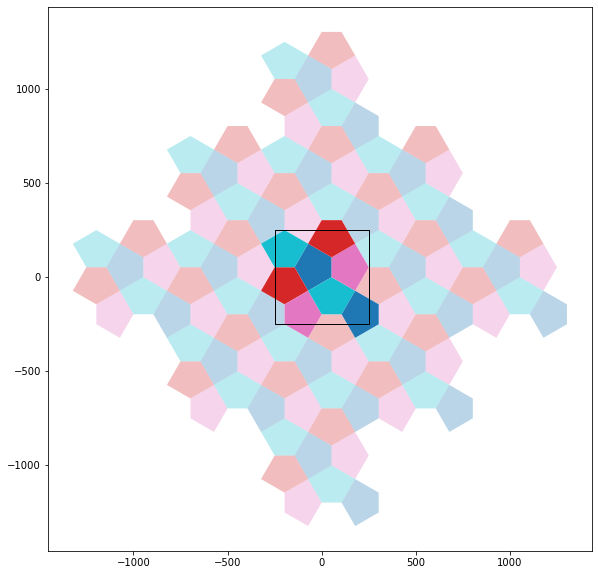

In [6]:
tile_unit = TileUnit(tiling_type = "cairo", spacing = 500, crs = ak.crs)
ax = tile_unit.get_local_patch(r = 2).plot(column = "element_id", alpha = 0.3,
                                           figsize = (10, 10))
tile_unit.elements.plot(ax = ax, column = "element_id")
tile_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

In [4]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map(prioritise_tiles = True)

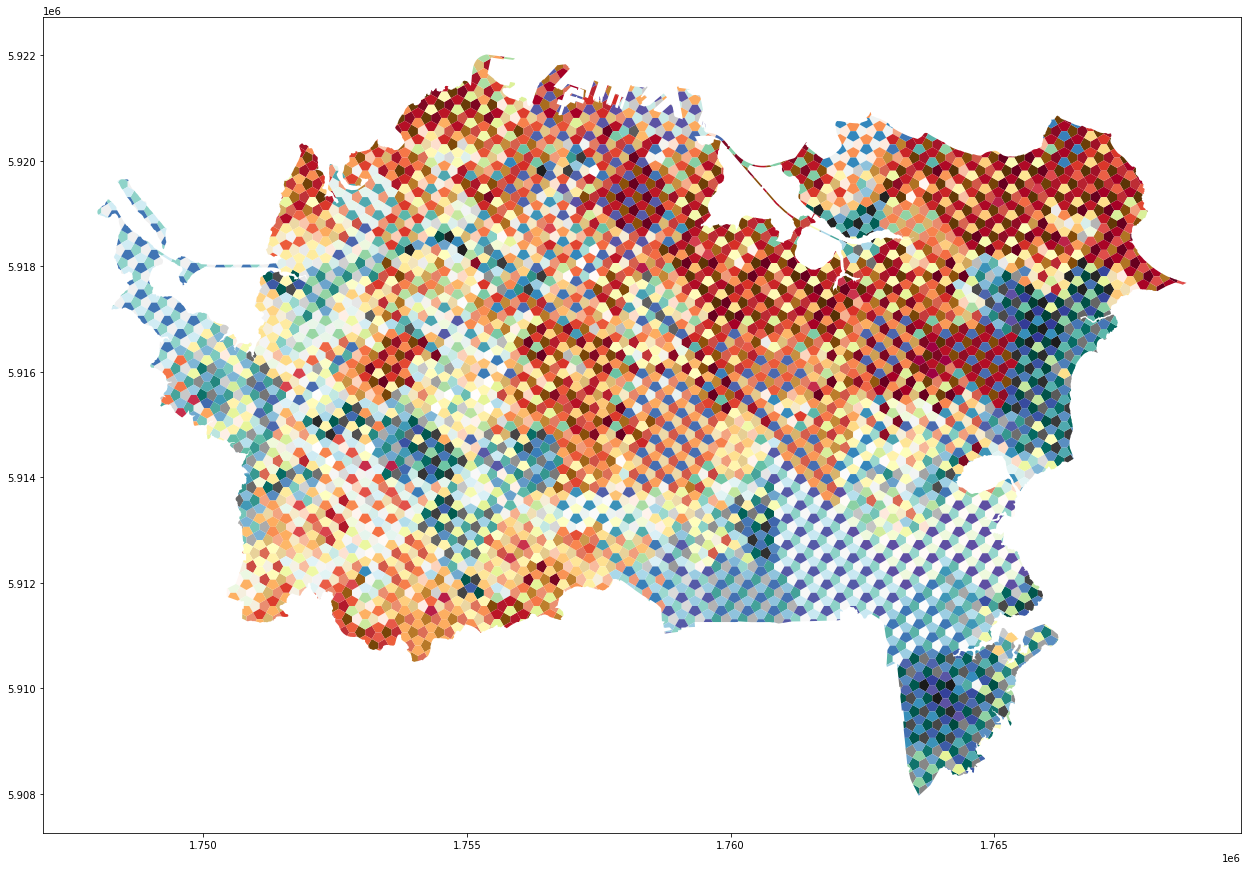

In [5]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("BrBG", "RdGy", "RdYlBu", "Spectral",
         "PiYG", "PRGn", "PuOr", "viridis")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)